In [30]:
import numpy as np
import pandas as pd
import sys
import os
import ipynbname

In [31]:
# Change cwd to project root to ensure relative paths work correctly.
# If moving the .ipynb file back to project root, simply remove the 2 lines below.
project_root = str(ipynbname.path().parent.parent)
os.chdir(project_root)

print(sys.version)
print(f"cwd: {os.getcwd()}")
print(f"Pandas version: {pd.__version__}")

3.13.0 (main, Oct 16 2024, 03:23:02) [Clang 18.1.8 ]
cwd: /home/christian/Schreibtisch/semester7/moderne-maskinlæring-i-praksis-TDT4173/group-project/main_predict_stock
Pandas version: 2.3.3


In [32]:
receivals_df = pd.read_csv('data/kernel/receivals.csv', parse_dates=['date_arrival'])
receivals_df['date_arrival'] = receivals_df['date_arrival'].apply(lambda x: x.date())

In [33]:
orders_df = pd.read_csv('data/kernel/purchase_orders.csv', parse_dates=['delivery_date', 'created_date_time', 'modified_date_time'])

orders_df['delivery_date'] = orders_df['delivery_date'].apply(lambda x: x.date())
orders_df['created_date_time'] = orders_df['created_date_time'].apply(lambda x: x.date())
orders_df['modified_date_time'] = orders_df['modified_date_time'].apply(lambda x: x.date())

In [34]:
orders_and_receivals = orders_df.merge(receivals_df, on=['purchase_order_id', 'purchase_order_item_no'], how='left', suffixes=('_order', '_receival'))

# print sum of net weight for receivals with purchase_order_id 257357
print("Sum of net weight for receivals with purchase_order_id 257357: ", orders_and_receivals.loc[orders_and_receivals['purchase_order_id'] == 257357, 'net_weight'].sum())

# For rows where unit is 'PUND', convert quantity and net_weight entries to kilograms
orders_and_receivals.loc[orders_and_receivals['unit'] == 'PUND', 'quantity'] *= 0.45359237
orders_and_receivals.loc[orders_and_receivals['unit'] == 'PUND', 'net_weight'] *= 0.45359237

# Drop unit and unit_id columns (assume that the 44 entries with na values in these columns are all in kilograms
orders_and_receivals = orders_and_receivals.drop(columns=['unit', 'unit_id'])

# Drop status, status_id suffices
orders_and_receivals = orders_and_receivals.drop(columns=['status'])

# Filter out rows with either rm_id or date_arrival being null
orders_and_receivals = orders_and_receivals[orders_and_receivals['rm_id'].notnull() & orders_and_receivals['date_arrival'].notnull()]

print(orders_and_receivals.info())

Sum of net weight for receivals with purchase_order_id 257357:  3000.0
<class 'pandas.core.frame.DataFrame'>
Index: 122533 entries, 10 to 133293
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   purchase_order_id       122533 non-null  int64  
 1   purchase_order_item_no  122533 non-null  int64  
 2   quantity                122533 non-null  float64
 3   delivery_date           122533 non-null  object 
 4   product_id_order        122533 non-null  int64  
 5   product_version         122533 non-null  int64  
 6   created_date_time       122533 non-null  object 
 7   modified_date_time      122124 non-null  object 
 8   status_id               122533 non-null  int64  
 9   rm_id                   122533 non-null  float64
 10  product_id_receival     122533 non-null  float64
 11  receival_item_no        122533 non-null  float64
 12  batch_id                64716 non-null   float64
 13  date_ar

In [35]:
def number_of_orders_last_year(ref_date, rm_id):
    num_orders_last_year_cache = {}
    if (ref_date, rm_id) in num_orders_last_year_cache:
        return num_orders_last_year_cache[(ref_date, rm_id)]

    start_date = (ref_date - pd.DateOffset(years=1)).date()
    mask = (orders_and_receivals['rm_id'] == rm_id) & (orders_and_receivals['created_date_time'] >= start_date) & (orders_and_receivals['created_date_time'] <= ref_date)
    filtered_orders = orders_and_receivals.loc[mask]
    num_orders_last_year_cache[(ref_date, rm_id)] = filtered_orders.shape[0]

    return num_orders_last_year_cache[(ref_date, rm_id)]

def total_weight_of_orders_last_year(ref_date, rm_id):
    weight_orders_last_year_cache = {}
    if (ref_date, rm_id) in weight_orders_last_year_cache:
        return weight_orders_last_year_cache[(ref_date, rm_id)]

    start_date = (ref_date - pd.DateOffset(years=1)).date()
    mask = (orders_and_receivals['rm_id'] == rm_id) & (orders_and_receivals['created_date_time'] >= start_date) & (orders_and_receivals['created_date_time'] <= ref_date)
    filtered_orders = orders_and_receivals.loc[mask]
    weight_orders_last_year_cache[(ref_date, rm_id)] = filtered_orders['net_weight'].sum()

    return weight_orders_last_year_cache[(ref_date, rm_id)]

def received_weight(start_date, end_date, rm_id):
    mask = (receivals_df['rm_id'] == rm_id) & (receivals_df['date_arrival'] >= start_date) & (receivals_df['date_arrival'] <= end_date)
    filtered_receivals = receivals_df.loc[mask]
    return filtered_receivals['net_weight'].sum()


In [36]:
def total_weight_same_window_last_year_row(row):
    """
    Method for adding this feature to a dataframe which doesn't already have it.
    Assumes the dataframe has columns year, month, day, interval_days, rm_id.
    """
    rm_id = row['rm_id']
    interval_days = row['interval_days']
    
    # reconstruct end_date from year, month, day
    end_date = pd.Timestamp(year=int(row['year']), month=int(row['month']), day=int(row['day'])).date()
    start_date = end_date - pd.Timedelta(days=interval_days-1)
    
    # Move window one year back
    prev_end = (end_date - pd.DateOffset(years=1)).date()
    prev_start = (start_date - pd.DateOffset(years=1)).date()
    
    return received_weight(prev_start, prev_end, rm_id)

In [37]:
create_train_df = False

if create_train_df:
    intervals = []
    unique_rm_ids = receivals_df['rm_id'].unique()

    for year in range(2022, 2024): # only 2024 for now
        for month in range(6, 7):  #
            for day in range(15, 16):  # Creating dataframe takes some time.
                print(f"Processing date: {year}-{month}-{day}")
                for window_len in range(1, 152):
                    window_start = pd.Timestamp(year=year, month=month, day=day).date()
                    window_end = (pd.Timestamp(window_start) + pd.Timedelta(days=window_len)).date()
                    for rm_id in unique_rm_ids:
                        total = received_weight(window_start, window_end, rm_id)
                        features = {
                            "rm_id": rm_id,
                            "interval_days": window_len,
                            "year": year,
                            "month": window_end.month,
                            "day": window_end.day,
                            "num_orders_last_year": number_of_orders_last_year(window_start, rm_id),
                            "total_weight_orders_last_year": total_weight_of_orders_last_year(window_start, rm_id),
                            "total_weight_last_year_same_window": received_weight((pd.Timestamp(window_start) - pd.DateOffset(years=1)).date(), (pd.Timestamp(window_end) - pd.DateOffset(years=1)).date(), rm_id)
                        }
                        intervals.append({**features, "target": total})

    train_df = pd.DataFrame(intervals)
    train_df['rm_id'] = train_df['rm_id'].astype("category")
    train_df.to_csv('christian/csv/christian_train_df.csv', index=False)

else:
    # Just read a large precomputed training dataframe
    train_df = pd.read_csv('christian/csv/christian_train_df.csv')
    train_df['rm_id'] = train_df['rm_id'].astype("category")

print(train_df.head())

   rm_id  interval_days  year  month  day  num_orders_last_year  \
0  365.0              1  2019      1    2                     0   
1  379.0              1  2019      1    2                     0   
2  389.0              1  2019      1    2                     0   
3  369.0              1  2019      1    2                     0   
4  366.0              1  2019      1    2                     0   

   total_weight_orders_last_year  target  total_weight_last_year_same_window  
0                            0.0     0.0                                 0.0  
1                            0.0     0.0                                 0.0  
2                            0.0     0.0                                 0.0  
3                            0.0     0.0                                 0.0  
4                            0.0     0.0                                 0.0  


In [38]:
X = train_df.drop(columns=['target'])
y = train_df['target']

import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    objective='reg:quantileerror',
    quantile_alpha=0.2,
    base_score=0.0,
    enable_categorical=True,
    device="cuda"
)

# (Optional) validation split—critical for time series generalization:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)  # Do NOT shuffle in time series context!

model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=True,
)

# Evaluate
from sklearn.metrics import mean_pinball_loss
y_pred = model.predict(X_val)
print("Pinball loss (quantile loss) on validation:", mean_pinball_loss(y_val, y_pred, alpha=0.2))

[0]	validation_0-quantile:15763.36974
[1]	validation_0-quantile:15745.49638
[2]	validation_0-quantile:15680.43228
[3]	validation_0-quantile:15682.76529
[4]	validation_0-quantile:15667.68280
[5]	validation_0-quantile:15650.20057
[6]	validation_0-quantile:15638.00520
[7]	validation_0-quantile:15621.51793
[8]	validation_0-quantile:15595.83316
[9]	validation_0-quantile:15586.88432
[10]	validation_0-quantile:15577.28737
[11]	validation_0-quantile:15560.25876
[12]	validation_0-quantile:15548.89076
[13]	validation_0-quantile:15507.68101
[14]	validation_0-quantile:15498.64125
[15]	validation_0-quantile:15428.35466
[16]	validation_0-quantile:15399.52853
[17]	validation_0-quantile:15350.83998
[18]	validation_0-quantile:15337.56613
[19]	validation_0-quantile:15322.71969
[20]	validation_0-quantile:15290.64447
[21]	validation_0-quantile:15282.81308
[22]	validation_0-quantile:15218.19965
[23]	validation_0-quantile:15199.44921
[24]	validation_0-quantile:15187.56274
[25]	validation_0-quantile:15181.28

In [ ]:
create_prediction_df = False

if create_prediction_df:
    prediction_map = pd.read_csv("data/prediction_mapping.csv")

    rm_ids = prediction_map['rm_id'].unique()
    interval_days = range(1, 151)
    year = 2025

    predict_df = pd.DataFrame([{
        "rm_id": rm_id,
        "interval_days": interval,
        "year": year,
        "month": (pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=interval)).month,
        "day": (pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=interval)).date().day,
        "num_orders_last_year": number_of_orders_last_year(pd.Timestamp(year=year, month=1, day=1).date(), rm_id),
        "total_weight_orders_last_year": total_weight_of_orders_last_year(pd.Timestamp(year=year, month=1, day=1).date(), rm_id),
        "total_weight_last_year_same_window": received_weight(
            (pd.Timestamp(year=year, month=1, day=1) - pd.DateOffset(years=1)).date(),
            (pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=interval) - pd.DateOffset(years=1)).date(),
            rm_id
        )
    } for rm_id in rm_ids for interval in interval_days])

else:
    predict_df = pd.read_csv('christian/csv/christian_predict_df.csv')
    predict_df['rm_id'] = predict_df['rm_id'].astype('category')

print(predict_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30450 entries, 0 to 30449
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   rm_id                               30450 non-null  category
 1   interval_days                       30450 non-null  int64   
 2   year                                30450 non-null  int64   
 3   month                               30450 non-null  int64   
 4   day                                 30450 non-null  int64   
 5   num_orders_last_year                30450 non-null  int64   
 6   total_weight_orders_last_year       30450 non-null  float64 
 7   total_weight_last_year_same_window  30450 non-null  float64 
dtypes: category(1), float64(2), int64(5)
memory usage: 1.7 MB
None


In [40]:
y_pred = model.predict(predict_df)
y_pred = np.maximum(0, y_pred)  # Ensure no negative predictions

pred2025 = pd.DataFrame({
    "ID": np.arange(1, len(y_pred) + 1),
    "predicted_weight": y_pred
})

pred2025.to_csv("christian/categorical_xgboost.csv", index=False)



In [41]:
prediction_mapping = pd.read_csv("data/prediction_mapping.csv")
merged = pred2025.merge(prediction_mapping, on="ID")

agg_df = merged.groupby("rm_id", as_index=False).agg({
    "predicted_weight": "max",
}).sort_values("predicted_weight", ascending=False)

print(agg_df.head(20))
# print(max(y_pred), min(y_pred), np.mean(y_pred), np.median(y_pred))

     rm_id  predicted_weight
75    2130      2.280040e+06
180   3865      2.057633e+06
176   3781      2.009994e+06
150   3125      1.381823e+06
151   3126      1.358914e+06
149   3124      1.305597e+06
160   3282      1.257893e+06
147   3122      1.254276e+06
148   3123      1.069429e+06
182   3901      7.045218e+05
83    2140      4.047141e+05
79    2134      4.011092e+05
85    2142      3.812789e+05
80    2135      1.992920e+05
190   4222      1.779153e+05
76    2131      1.739715e+05
87    2144      1.605528e+05
191   4263      1.501804e+05
196   4441      1.321375e+05
181   3883      1.294231e+05


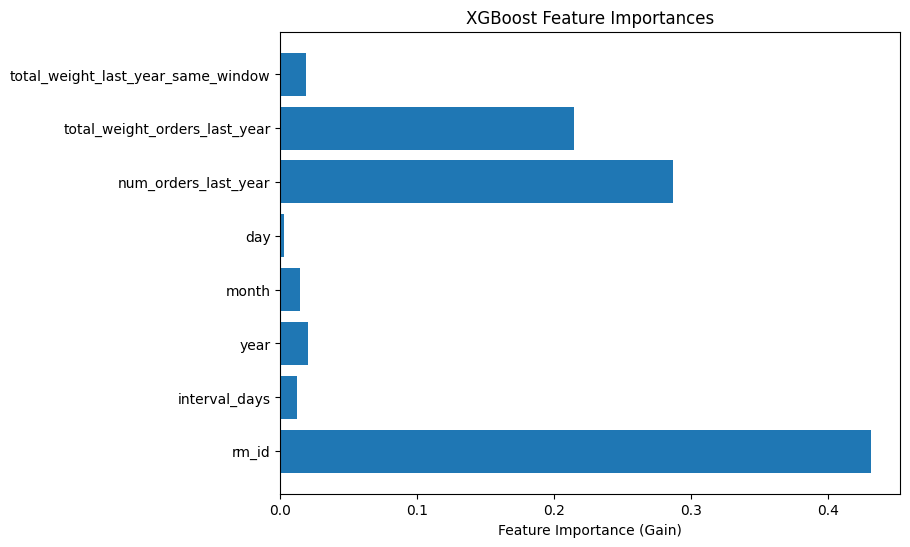

In [42]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,6))
plt.barh(features, importances)
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Feature Importances")
plt.show()

/home/christian/Schreibtisch/semester7/moderne-maskinlæring-i-praksis-TDT4173/group-project/main_predict_stock/christian/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


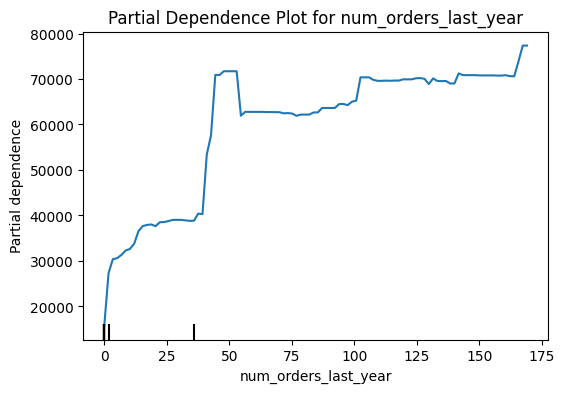

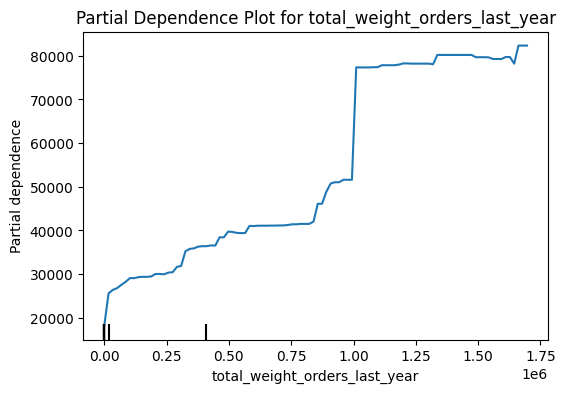

In [43]:
from sklearn.inspection import PartialDependenceDisplay

# Picking the most important feature from above
orders_last_year_index = 5
total_weight_last_year_index = 6
target_features = [X.columns[orders_last_year_index], X.columns[total_weight_last_year_index]]

def plot_target_feature(model, X, target_feature):
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(model, X, [target_feature], ax=ax)
    plt.title(f"Partial Dependence Plot for {target_feature}")
    plt.show()

for feature in target_features:
    plot_target_feature(model, X, feature)


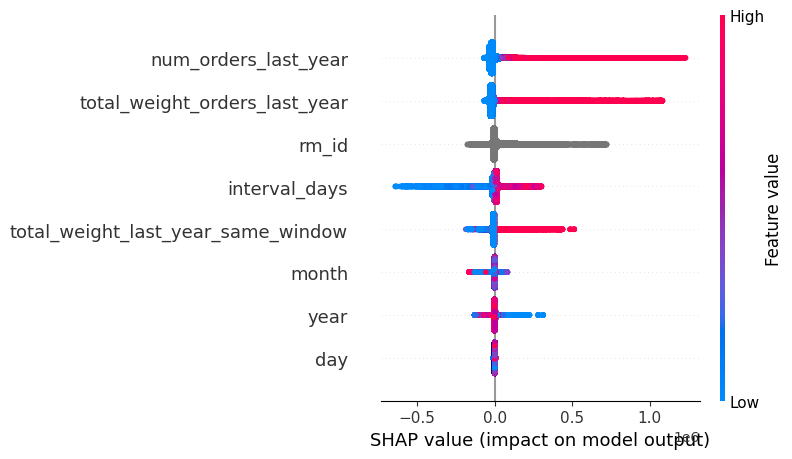

In [44]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X, check_additivity=False)

shap.summary_plot(shap_values, X, show=True)